In [1]:
import os

import numpy as np
import pandas as pd
import json
import cv2
import sklearn
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K

In [2]:
from tensorflow.python.client import device_lib
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [3]:
# f = open("C:\school\minor-ai\lettuce-cnn\data\measurements.json")
f = open("C:/Users/joren/Downloads/wur_dataset/GroundTruth/GroundTruth_All_388_Images.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [4]:
df.sort_values("Height")

,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
248,Lugano,RGB_9.png,Depth_9.png,2.5,0.10,4.3,9.8,72.2
338,Aphylion,RGB_17.png,Depth_17.png,2.8,0.12,5.0,14.5,67.2
234,Salanova,RGB_10.png,Depth_10.png,1.4,0.09,5.1,13.0,57.6
219,Aphylion,RGB_15.png,Depth_15.png,3.2,0.16,5.1,16.1,87.6
111,Satine,RGB_61.png,Depth_61.png,3.3,0.24,5.2,13.0,89.0
...,...,...,...,...,...,...,...,...
55,Aphylion,RGB_347.png,Depth_347.png,444.7,17.24,24.0,34.5,4995.6
247,Aphylion,RGB_362.png,Depth_362.png,336.0,13.53,24.0,39.0,4429.8
54,Aphylion,RGB_346.png,Depth_346.png,364.8,14.69,24.5,33.0,4516.2
321,Aphylion,RGB_343.png,Depth_343.png,406.0,15.97,25.0,30.0,5379.9


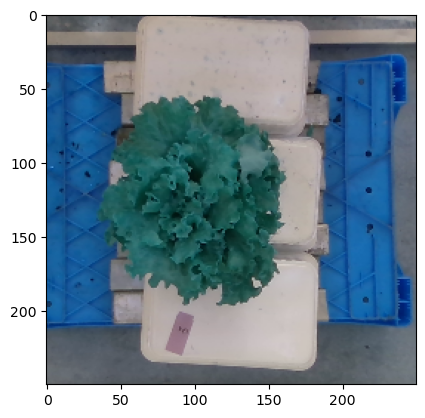

In [36]:
# testing images shaping
# img = cv2.imread('C:\school\minor-ai\lettuce-cnn\data\RGBImages\RGB_270.png')
img = cv2.imread('C:/Users/joren/Downloads/wur_dataset/data/RGBImages/RGB_270.png')
w, h, c = img.shape

img = img[ (w // 2 - 400 ) : (w // 2 + 400) , (h // 2 - 400 + 100)  : (h // 2 + 400 + 100) ]
plt.imshow(img)

In [37]:

# path = "./data/DepthImages/"
path = 'C:/Users/joren/Downloads/wur_dataset/data/DepthImages/'
all_images = []
y = []
for image_path in os.listdir(path):
    y.append(df.loc[df['Depth_Information'] == image_path].Height.item())
    img = cv2.imread(path + image_path, -1)
    img = img[ (w // 2 - 400 ) : (w // 2 + 400) , (h // 2 - 400 + 100)  : (h // 2 + 400 + 100) ]
    img = cv2.resize(img, (250, 250))
    all_images.append(img)
print(y)
X = np.array(all_images)


[8.2, 5.1, 7.1, 6.5, 7.0, 6.5, 6.6, 8.7, 8.6, 7.3, 8.1, 8.2, 5.6, 7.8, 10.3, 8.4, 7.5, 7.0, 9.2, 6.0, 6.8, 7.0, 7.5, 7.1, 7.1, 6.2, 7.5, 7.9, 8.0, 8.4, 8.8, 7.0, 7.8, 8.5, 10.1, 8.4, 8.7, 11.6, 10.8, 9.3, 10.6, 9.8, 12.9, 10.1, 8.9, 5.6, 11.6, 12.0, 11.2, 10.6, 11.5, 13.3, 10.4, 13.7, 11.3, 11.0, 5.1, 11.3, 9.0, 11.3, 12.5, 12.1, 11.3, 13.1, 12.8, 11.0, 13.2, 9.6, 12.2, 10.3, 12.5, 9.8, 13.4, 13.5, 13.9, 11.3, 13.1, 13.5, 5.0, 11.0, 12.4, 9.5, 12.4, 12.0, 14.5, 12.3, 12.1, 15.0, 11.2, 6.2, 12.0, 11.3, 9.2, 11.8, 10.6, 10.0, 10.3, 9.8, 11.9, 12.1, 5.4, 10.8, 9.5, 11.3, 9.0, 9.4, 12.0, 11.0, 12.0, 11.0, 13.0, 8.5, 8.5, 12.0, 13.0, 14.0, 11.0, 12.0, 13.0, 13.0, 10.0, 9.0, 8.0, 7.9, 12.0, 12.0, 8.0, 14.0, 9.0, 10.5, 10.0, 11.0, 11.0, 15.0, 5.4, 14.0, 17.0, 16.0, 15.0, 12.0, 14.0, 16.0, 16.5, 16.0, 11.0, 8.5, 11.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0, 13.0, 13.0, 7.8, 11.0, 16.0, 17.5, 13.0, 16.4, 17.0, 15.0, 13.5, 15.0, 14.8, 6.5, 15.5, 13.5, 12.9, 11.1, 14.0, 15.8, 16.5, 12.1, 15.5, 

In [38]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [39]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [10]:


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(800, 800, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss="mean_squared_error", optimizer="adam", metrics=[r2_keras])
model.summary()
# mean squared error
# mean absolute error percentage
# r2 score

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 798, 798, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 399, 399, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 397, 397, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 198, 198, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 196, 196, 64)      36928     
                                                                 
 dense (Dense)               (None, 196, 196, 1)       6

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          verbose=2,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/30


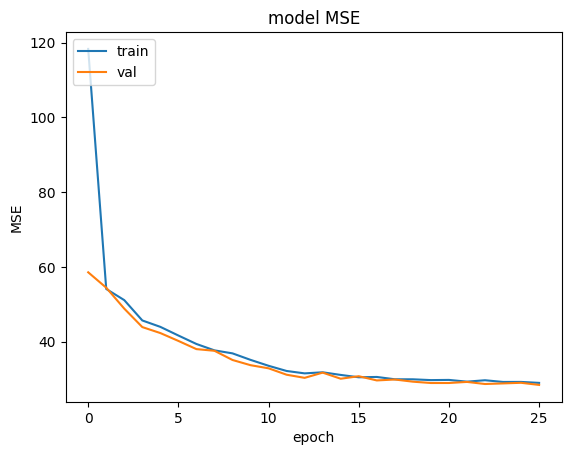

In [286]:
plt.plot(history.history['loss'][4 : ])
plt.plot(history.history['val_loss'][4: ])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.predict([X_train[0]])

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [40]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [41]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [42]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [43]:
def create_res_net(input_shape, regression):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(19, activation='softmax')(t)

    if regression:
        outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    if regression:
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )
    else:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

In [44]:
rn = create_res_net((250,250,1),True)

In [45]:
rn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_90 (BatchN  (None, 250, 250, 1)  4          ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_96 (Conv2D)             (None, 250, 250, 64  640         ['batch_normalization_90[0][0]'] 
                                )                                                           

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'res_net_depth'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir=f'tensorboard_logs/{name}',
    histogram_freq=1
)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
print(X_train.get_shape())
rn.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    verbose=1,
    validation_data=(X_test, y_test),
    batch_size=16,
    callbacks=[cp_callback, tensorboard_callback]
)

(310, 250, 250)
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 6.3316 - mean_absolute_percentage_error: 18.8602
Epoch 1: saving model to checkpoints/res_net_depth20221206-114207\cp-0001.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0001.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0001.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 6.3316 - mean_absolute_percentage_error: 18.8602 - val_loss: 30.5157 - val_mean_absolute_percentage_error: 27.8470
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 4.7581 - mean_absolute_percentage_error: 14.9169
Epoch 2: saving model to checkpoints/res_net_depth20221206-114207\cp-0002.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0002.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0002.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 4.7581 - mean_absolute_percentage_error: 14.9169 - val_loss: 29.0178 - val_mean_absolute_percentage_error: 34.9624
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 4.8179 - mean_absolute_percentage_error: 15.3122
Epoch 3: saving model to checkpoints/res_net_depth20221206-114207\cp-0003.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0003.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0003.ckpt\assets


20/20 [==============================] - 33s 2s/step - loss: 4.8179 - mean_absolute_percentage_error: 15.3122 - val_loss: 27.0914 - val_mean_absolute_percentage_error: 32.9241
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 6.2882 - mean_absolute_percentage_error: 18.8397
Epoch 4: saving model to checkpoints/res_net_depth20221206-114207\cp-0004.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0004.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0004.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 6.2882 - mean_absolute_percentage_error: 18.8397 - val_loss: 11.3995 - val_mean_absolute_percentage_error: 22.8442
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 4.7147 - mean_absolute_percentage_error: 17.2526
Epoch 5: saving model to checkpoints/res_net_depth20221206-114207\cp-0005.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0005.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0005.ckpt\assets


20/20 [==============================] - 33s 2s/step - loss: 4.7147 - mean_absolute_percentage_error: 17.2526 - val_loss: 19.1411 - val_mean_absolute_percentage_error: 36.4503
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 4.0442 - mean_absolute_percentage_error: 15.2538
Epoch 6: saving model to checkpoints/res_net_depth20221206-114207\cp-0006.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0006.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0006.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 4.0442 - mean_absolute_percentage_error: 15.2538 - val_loss: 21.7047 - val_mean_absolute_percentage_error: 35.4470
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 9.4143 - mean_absolute_percentage_error: 23.1155
Epoch 7: saving model to checkpoints/res_net_depth20221206-114207\cp-0007.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0007.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0007.ckpt\assets


20/20 [==============================] - 33s 2s/step - loss: 9.4143 - mean_absolute_percentage_error: 23.1155 - val_loss: 10.3704 - val_mean_absolute_percentage_error: 19.4629
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 6.3539 - mean_absolute_percentage_error: 18.5854
Epoch 8: saving model to checkpoints/res_net_depth20221206-114207\cp-0008.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0008.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0008.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 6.3539 - mean_absolute_percentage_error: 18.5854 - val_loss: 5.1403 - val_mean_absolute_percentage_error: 16.5058
Epoch 9/100
20/20 [==============================] - ETA: 0s - loss: 3.8165 - mean_absolute_percentage_error: 14.5475
Epoch 9: saving model to checkpoints/res_net_depth20221206-114207\cp-0009.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0009.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0009.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 3.8165 - mean_absolute_percentage_error: 14.5475 - val_loss: 5.3485 - val_mean_absolute_percentage_error: 16.0296
Epoch 10/100
20/20 [==============================] - ETA: 0s - loss: 4.6189 - mean_absolute_percentage_error: 15.9445
Epoch 10: saving model to checkpoints/res_net_depth20221206-114207\cp-0010.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0010.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0010.ckpt\assets


20/20 [==============================] - 33s 2s/step - loss: 4.6189 - mean_absolute_percentage_error: 15.9445 - val_loss: 8.5604 - val_mean_absolute_percentage_error: 19.6054
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 7.6180 - mean_absolute_percentage_error: 22.1858
Epoch 11: saving model to checkpoints/res_net_depth20221206-114207\cp-0011.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0011.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0011.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 7.6180 - mean_absolute_percentage_error: 22.1858 - val_loss: 3.7227 - val_mean_absolute_percentage_error: 11.5557
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 7.2853 - mean_absolute_percentage_error: 22.4452
Epoch 12: saving model to checkpoints/res_net_depth20221206-114207\cp-0012.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0012.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0012.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 7.2853 - mean_absolute_percentage_error: 22.4452 - val_loss: 6.9462 - val_mean_absolute_percentage_error: 19.0375
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 4.1140 - mean_absolute_percentage_error: 15.3496
Epoch 13: saving model to checkpoints/res_net_depth20221206-114207\cp-0013.ckpt


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0013.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net_depth20221206-114207\cp-0013.ckpt\assets


20/20 [==============================] - 34s 2s/step - loss: 4.1140 - mean_absolute_percentage_error: 15.3496 - val_loss: 16.6070 - val_mean_absolute_percentage_error: 19.2101
Epoch 14/100
20/20 [==============================] - ETA: 0s - loss: 4.0297 - mean_absolute_percentage_error: 14.4007
Epoch 14: saving model to checkpoints/res_net_depth20221206-114207\cp-0014.ckpt


FailedPreconditionError: {{function_node __wrapped__SaveV2_dtypes_448_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to rename: checkpoints/res_net_depth20221206-114207\cp-0014.ckpt\variables\variables_temp/part-00000-of-00001.data-00000-of-00001.tempstate15686874212932515873 to: checkpoints/res_net_depth20221206-114207\cp-0014.ckpt\variables\variables_temp/part-00000-of-00001.data-00000-of-00001 : The process cannot access the file because it is being used by another process.
; Broken pipe [Op:SaveV2]

In [50]:
# rn.predict([X_test[0]])

ValueError: in user code:

    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\input_spec.py", line 233, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model_3" "                 f"(type Functional).
    
    Input 0 of layer "batch_normalization_90" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 250)
    
    Call arguments received by layer "model_3" "                 f"(type Functional):
      • inputs=('tf.Tensor(shape=(None, 250), dtype=uint16)',)
      • training=False
      • mask=None
